In [ ]:
!pip install -r requirements.txt

기간수익률 : 616.4449511981627 % , 최대손실률 : -49.935296206479464 % , 수수료 : 0.05 %
알고리즘 적용 없을 시 수익률 : 1018.0221678848701 %


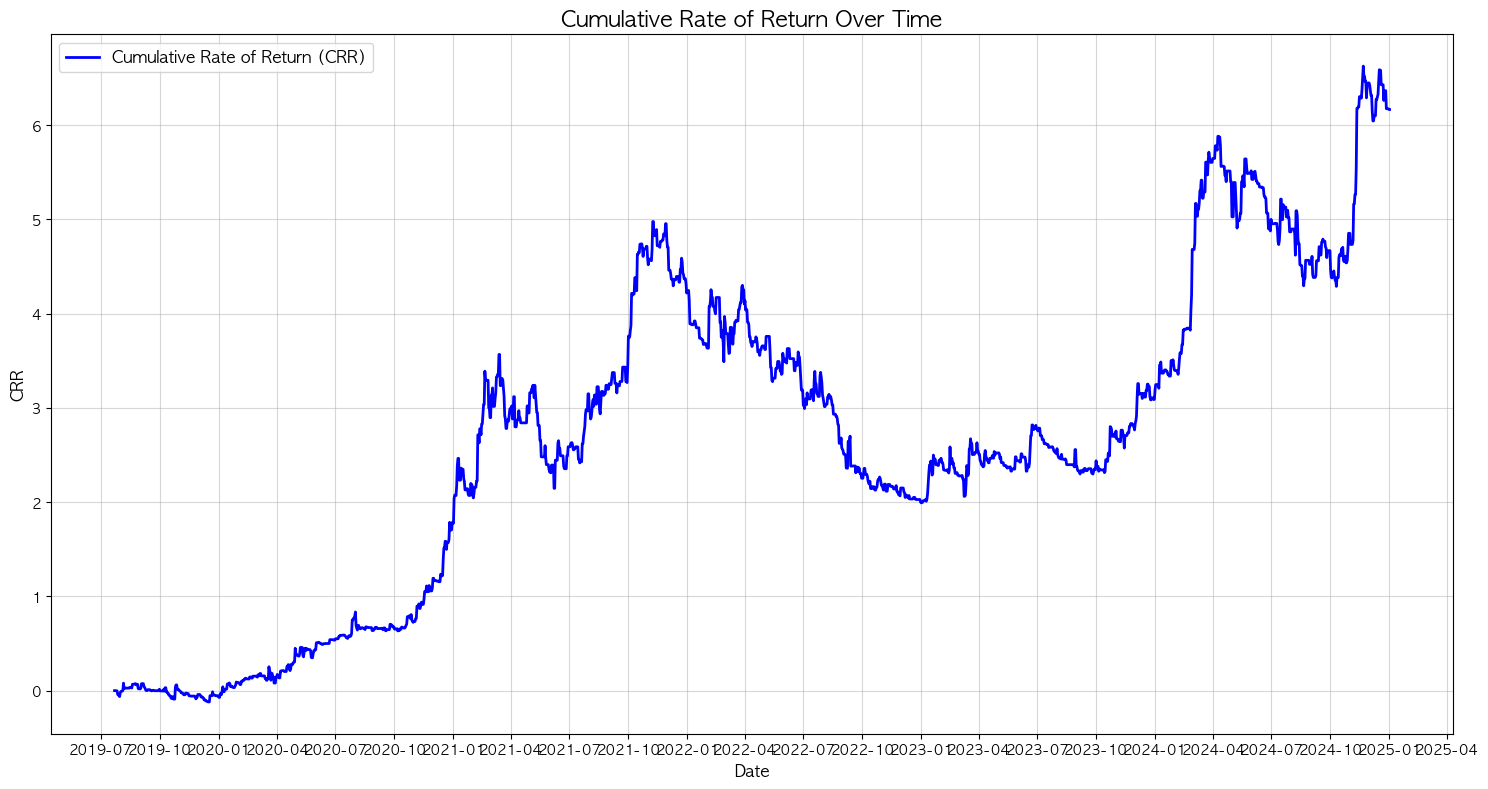

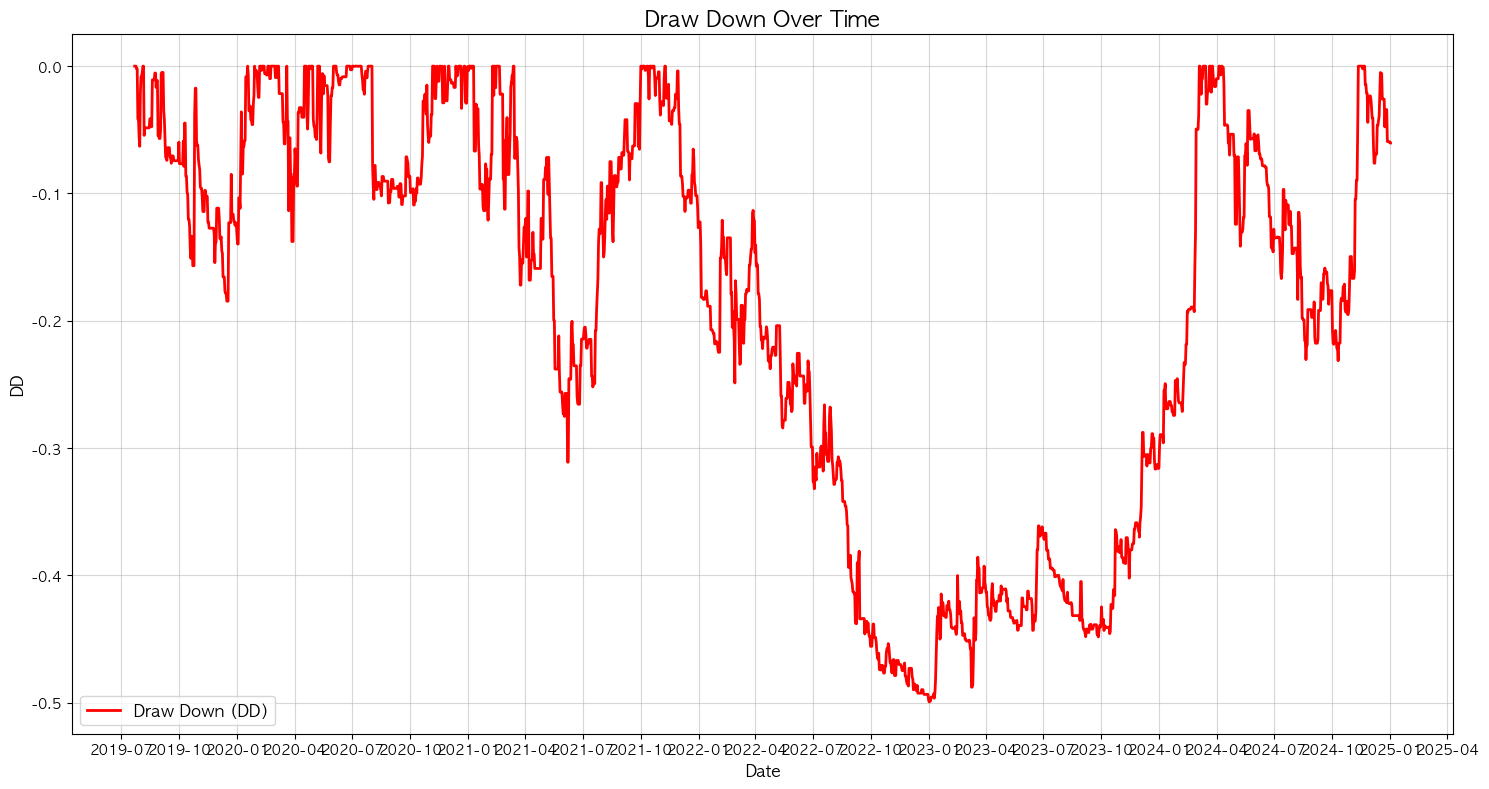

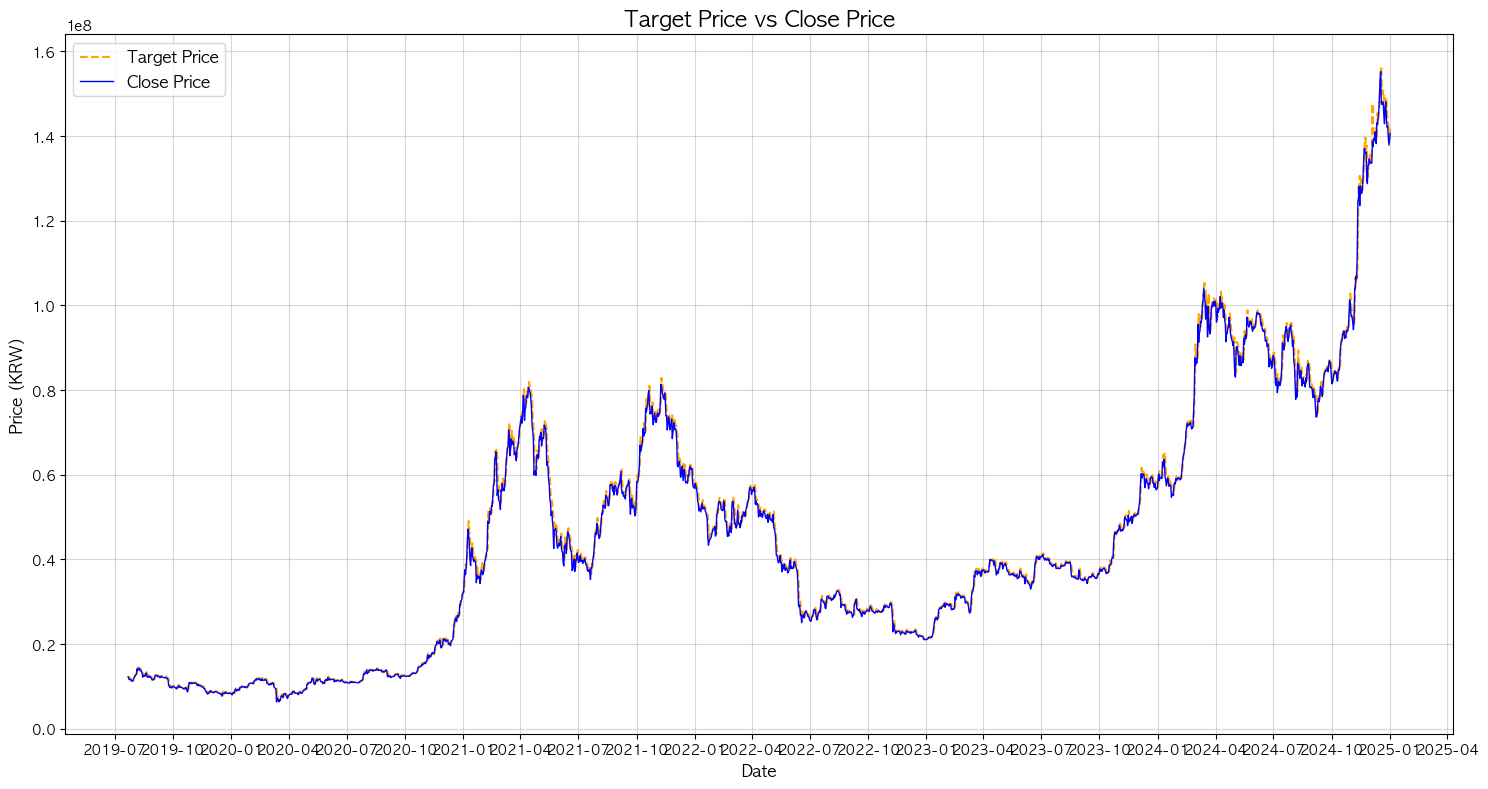

In [33]:
# https://poalim.tistory.com/m/29
# https://github.com/poArlim/crypto-auto-trading

# K 값이 너무 낮으면:
# 목표가가 지나치게 낮게 설정되어 불필요한 매수가 발생.
# 변동성이 큰 시장에서 손실 위험이 커짐.
# K 값이 너무 높으면:
# 목표가가 지나치게 높아져 매수 신호가 거의 발생하지 않음.
# 투자 기회를 놓칠 가능성이 큼.

import pyupbit
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 한글 폰트 설정 (Mac: AppleGothic)
plt.rc('font', family='AppleGothic')     # Mac: 
# plt.rc('font', family='NanumGothic')   # Linux: 나눔고딕
# plt.rc('font', family='Malgun Gothic') # Windows:

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

coin = "KRW-BTC"		# 분석할 코인
interval = "day"		# 일간 차트 기준
fees = 0.0005			# 매매 수수료
day_count = 2000		# 가져오는 총 데이터 일 수(1300일치 데이터)
K = 0.3                 # 변동성 돌파 전략의 K 값 (가중치) - 과거 변동성의 50%를 반영

date = None             # 데이터를 반복적으로 가져올 때 기준 날짜를 설정
dfs = []                # 가져온 데이터를 저장할 리스트

# 업비트는 한번에 200 데이터만 반환하기 때문에 데이터를 나누어 여러번 요청
for i in range(day_count // 200 + 1):

    # 초기 데이터 요청
    # 첫 번째 요청 시 date는 None이므로 가장 최신 데이터를 가져옴
    # df.index[0]: 반환된 데이터의 첫 번째 날짜를 가져와 date에 저장
    if i < day_count // 200 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval)
        date = df.index[0]

    # 남은 데이터 요청
    # elif day_count % 200 != 0: 요청한 총 데이터가 200의 배수가 아닐 경우 남은 데이터를 가져옴
    elif day_count % 200 != 0 :
        df = pyupbit.get_ohlcv(coin, to = date, interval = interval, count = day_count % 200)
    
    # 필요한 데이터를 모두 가져왔으면 반복을 종료
    else :
        break
    dfs.append(df)
    time.sleep(0.1)

# 각 반복에서 가져온 데이터를 dfs 리스트에 저장한 후, Pandas의 concat 함수를 이용해 병합.
# 날짜순으로 정렬하여 최종 데이터프레임(df) 생성.
df = pd.concat(dfs).sort_index()

# open(시가), high(고가), low(저가), close(종가), volume(거래량)

# 3.1 변동성 돌파 전략
# range: 전일 고가와 저가의 차이를 계산.
# targetPrice: 당일 시가에 전일 변동폭의 50%를 더한 값.
df['range'] = df['high'].shift(1) - df['low'].shift(1)  # 전일 변동폭   
df['targetPrice'] = df['open'] + df['range'] * K        # 목표가      

# 3.2 수익률 계산
# drr: 단일 거래 수익률. 목표가를 초과하면 수익률 계산, 아니면 0.
# crr: 누적 수익률. cumprod를 사용해 매일의 수익률을 곱.
# dd: 최대 손실률. 누적 수익률의 최고점과 현재값의 차이를 계산.
df['drr'] = np.where(df['high'] > df['targetPrice'], (df['close'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) - 1 , 0)
df['crr'] = (df['drr'] + 1).cumprod() - 1
df['dd'] = -(((df['crr'] + 1).cummax() - (df['crr'] + 1)) / (df['crr'] + 1).cummax())


# 기간 수익률: 알고리즘을 적용한 경우의 최종 수익률.
# 최대 손실률: 투자 기간 중 손실의 최대치.
# 수수료: 매매 시 적용된 수수료 비율.
# 알고리즘 미적용 수익률: 단순히 매수 후 홀딩했을 때의 수익률.
print("기간수익률 :", df['crr'].iloc[-1] * 100, "% , 최대손실률 :", df['dd'].min() * 100, "% , 수수료 :", fees * 100, "%")
print("알고리즘 적용 없을 시 수익률 :", ((df['close'].iloc[-1]/(1+fees))/(df['open'].iloc[0]*(1+fees))-1) * 100, "%")

# Visualization
# Plotting Cumulative Rate of Return (CRR)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['crr'], label="Cumulative Rate of Return (CRR)", linewidth=2, color='blue')
plt.title("Cumulative Rate of Return Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("CRR", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting Draw Down (DD)
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['dd'], label="Draw Down (DD)", color='red', linewidth=2)
plt.title("Draw Down Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("DD", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting Target Price vs Close Price
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['targetPrice'], label="Target Price", color='orange', linestyle='--')
plt.plot(df.index, df['close'], label="Close Price", color='blue', linewidth=1)
plt.title("Target Price vs Close Price", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (KRW)", fontsize=12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # 3개월 단위
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식
plt.grid(alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()




K 값별 누적 수익률, 최대 손실률 및 점수:
   K 값  누적 수익률 (CRR)  최대 손실률 (DD)        점수
2  0.3      6.164450    -0.499353  5.665097
6  0.7      5.250585    -0.380562  4.870023
7  0.8      4.022520    -0.283994  3.738526
8  0.9      3.682249    -0.164319  3.517930
4  0.5      3.735411    -0.499388  3.236023
3  0.4      3.636765    -0.605326  3.031440
5  0.6      3.144952    -0.425894  2.719059
1  0.2      1.412053    -0.657025  0.755028
0  0.1     -0.121732    -0.885767 -1.007499

**최적 K 값 추천 결과**
최적 K 값: 0.3
최적 누적 수익률 (CRR): 616.44%
최대 손실률 (DD): -49.94%
점수 (CRR - DD): 5.6651

**K 값 선택 기준**
1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.
2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.
3. 추천: K=0.3는 616.44%의 누적 수익률과 -49.94%의 최대 손실률을 제공합니다.
4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음


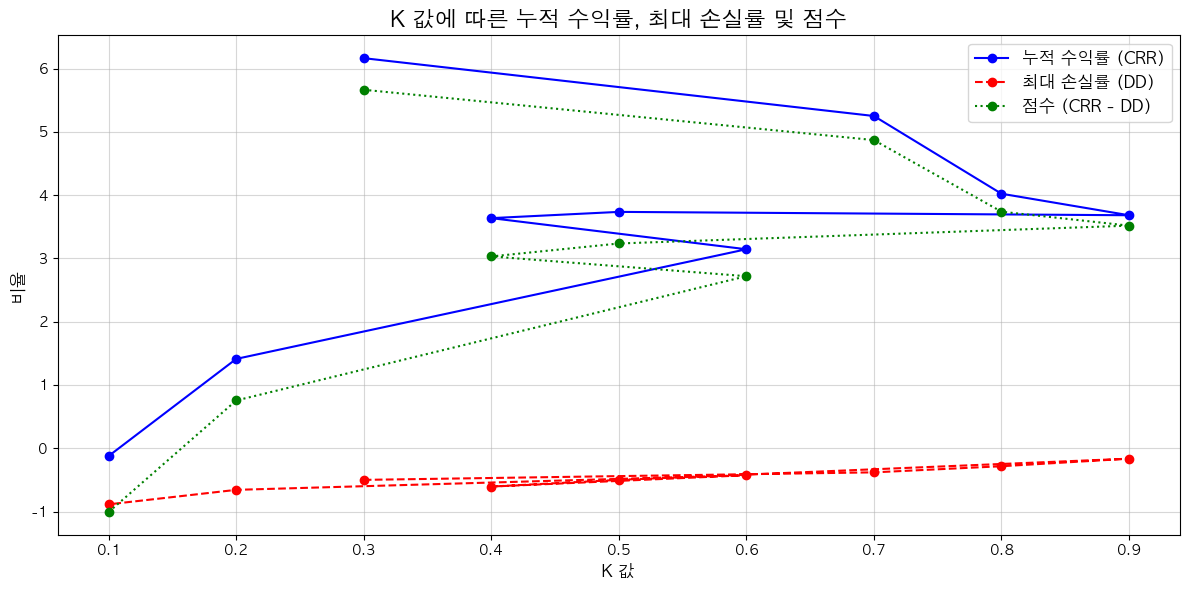

In [31]:
# K 값에 따른 누적 수익률과 최대 손실률 계산
best_k = 0
best_score = -float('inf')  # 초기값 설정
results = []

for k in np.arange(0.1, 1.0, 0.1):
    df['range'] = df['high'].shift(1) - df['low'].shift(1)
    df['targetPrice'] = df['open'] + df['range'] * k
    df['drr'] = np.where(df['high'] > df['targetPrice'], 
                         (df['close'] / (1 + fees)) / (df['targetPrice'] * (1 + fees)) - 1, 0)
    df['crr'] = (df['drr'] + 1).cumprod() - 1
    dd = -(((df['crr'] + 1).cummax() - (df['crr'] + 1)) / (df['crr'] + 1).cummax())  # 최대 손실률 계산
    crr = df['crr'].iloc[-1]  # 최종 누적 수익률
    score = crr - abs(dd.min())  # 점수 계산 (수익률 - 손실률)
    results.append((k, crr, dd.min(), score))  # 결과 저장
    
    if score > best_score:  # 점수 기준으로 최적 값 갱신
        best_k = k
        best_score = score

# 결과를 데이터프레임으로 정리
result_df = pd.DataFrame(results, columns=["K 값", "누적 수익률 (CRR)", "최대 손실률 (DD)", "점수"])
result_df = result_df.sort_values(by="점수", ascending=False)

# 최적 K 값 정보
optimal_result = result_df.iloc[0]
optimal_k = optimal_result["K 값"]
optimal_crr = optimal_result["누적 수익률 (CRR)"]
optimal_dd = optimal_result["최대 손실률 (DD)"]
optimal_score = optimal_result["점수"]

# 결과 출력
print("\nK 값별 누적 수익률, 최대 손실률 및 점수:")
print(result_df)

print("\n**최적 K 값 추천 결과**")
print(f"최적 K 값: {optimal_k:.1f}")
print(f"최적 누적 수익률 (CRR): {optimal_crr * 100:.2f}%")
print(f"최대 손실률 (DD): {optimal_dd * 100:.2f}%")
print(f"점수 (CRR - DD): {optimal_score:.4f}")

# 선택 기준 설명
print("\n**K 값 선택 기준**")
print("1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.")
print("2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.")
print(f"3. 추천: K={optimal_k:.1f}는 {optimal_crr * 100:.2f}%의 누적 수익률과 {optimal_dd * 100:.2f}%의 최대 손실률을 제공합니다.")
print("4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음")





# 시각화
k_values = result_df["K 값"]
crr_values = result_df["누적 수익률 (CRR)"]
dd_values = result_df["최대 손실률 (DD)"]
scores = result_df["점수"]

plt.figure(figsize=(12, 6))
plt.plot(k_values, crr_values, marker='o', linestyle='-', color='blue', label="누적 수익률 (CRR)")
plt.plot(k_values, dd_values, marker='o', linestyle='--', color='red', label="최대 손실률 (DD)")
plt.plot(k_values, scores, marker='o', linestyle=':', color='green', label="점수 (CRR - DD)")
plt.title("K 값에 따른 누적 수익률, 최대 손실률 및 점수", fontsize=16)
plt.xlabel("K 값", fontsize=12)
plt.ylabel("비율", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


# 전날 고가: 100원, 저가: 90원 → 변동폭: 10원.
# 오늘 시가(시작 가격): 95원.
# 목표가: 95원 + (변동폭 × K) (K는 0.5 같은 설정 값).
# 만약 K=0.5라면, 목표가 = 95 + (10 × 0.5) = 100원.
# 오늘 가격이 100원을 넘으면 매수, 그날 종가에 매도.

# 전날 고가: 100,000원
# 전날 저가: 90,000원
# 전날 변동폭: 고가 - 저가 = 10,000원
# 오늘 시가: 95,000원
# K 값: 0.3

# 계산
# 목표가 설정:
# 목표가 = 오늘 시가 + (전날 변동폭 × K)
# 목표가 = 95,000 + (10,000 × 0.3) = 95,000 + 3,000 = 98,000원

# 매수/매도 시점
# 매수:
# 오늘의 가격이 98,000원을 넘으면 매수.
# 예를 들어, 오늘 가격이 오전 10시에 98,500원을 기록하면 매수 실행.
# 매도:
# **종가(하루의 마지막 가격)**에 매도.
# 예를 들어, 오늘 종가가 100,000원이라면 매도.

# 결과 계산
# 수익률 (수수료는 무시):
# 매수 가격: 98,500원
# 매도 가격: 100,000원
# 수익률 = (매도 가격 / 매수 가격 - 1) × 100
# 수익률 = (100,000 / 98,500 - 1) × 100 ≈ 1.52%

# 요약
# K = 0.3일 때, 오늘 목표가는 98,000원으로 설정.
# 목표가를 넘는 순간 매수하고, 하루가 끝나는 종가에 매도.
# 이 경우 1.52%의 수익률을 기록.



K 값별 누적 수익률, 최대 손실률 및 점수:
   K 값  누적 수익률 (CRR)  최대 손실률 (DD)        점수
2  0.3      6.164450    -0.499353  5.665097
6  0.7      5.250585    -0.380562  4.870023
7  0.8      4.022520    -0.283994  3.738526
8  0.9      3.682249    -0.164319  3.517930
4  0.5      3.735411    -0.499388  3.236023
3  0.4      3.636765    -0.605326  3.031440
5  0.6      3.144952    -0.425894  2.719059
1  0.2      1.412053    -0.657025  0.755028
0  0.1     -0.121732    -0.885767 -1.007499

**최적 K 값 추천 결과**
최적 K 값: 0.3
최적 누적 수익률 (CRR): 616.44%
최대 손실률 (DD): -49.94%
점수 (CRR - DD): 5.6651

**K 값 선택 기준**
1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.
2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.
3. 추천: K=0.3는 616.44%의 누적 수익률과 -49.94%의 최대 손실률을 제공합니다.
4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음


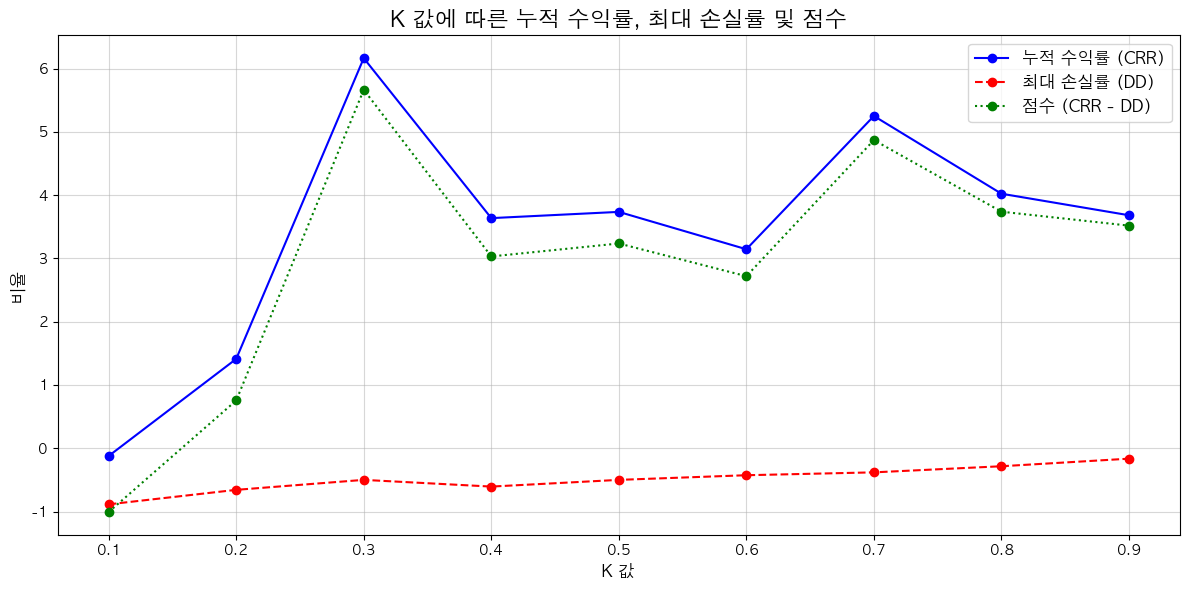

In [ ]:
# 결과를 데이터프레임으로 정리 (점수 기준 정렬)
result_df = pd.DataFrame(results, columns=["K 값", "누적 수익률 (CRR)", "최대 손실률 (DD)", "점수"])
result_df_sorted_by_score = result_df.sort_values(by="점수", ascending=False)  # 점수 기준 정렬
result_df = result_df.sort_values(by="K 값")  # 그래프를 위해 K 값 기준으로 정렬

# 최적 K 값 정보
optimal_result = result_df_sorted_by_score.iloc[0]
optimal_k = optimal_result["K 값"]
optimal_crr = optimal_result["누적 수익률 (CRR)"]
optimal_dd = optimal_result["최대 손실률 (DD)"]
optimal_score = optimal_result["점수"]

# 결과 출력
print("\nK 값별 누적 수익률, 최대 손실률 및 점수:")
print(result_df_sorted_by_score)

print("\n**최적 K 값 추천 결과**")
print(f"최적 K 값: {optimal_k:.1f}")
print(f"최적 누적 수익률 (CRR): {optimal_crr * 100:.2f}%")
print(f"최대 손실률 (DD): {optimal_dd * 100:.2f}%")
print(f"점수 (CRR - DD): {optimal_score:.4f}")

# 선택 기준 설명
print("\n**K 값 선택 기준**")
print("1. 높은 누적 수익률과 낮은 최대 손실률을 동시에 고려.")
print("2. 점수(누적 수익률(CRR) - 최대 손실률(DD))가 가장 높은 값을 선택.")
print(f"3. 추천: K={optimal_k:.1f}는 {optimal_crr * 100:.2f}%의 누적 수익률과 {optimal_dd * 100:.2f}%의 최대 손실률을 제공합니다.")
print("4. 점수가 높은 K 값일수록 수익률 대비 위험이 적음")

# 시각화
k_values = result_df["K 값"]
crr_values = result_df["누적 수익률 (CRR)"]
dd_values = result_df["최대 손실률 (DD)"]
scores = result_df["점수"]

plt.figure(figsize=(12, 6))
plt.plot(k_values, crr_values, marker='o', linestyle='-', color='blue', label="누적 수익률 (CRR)")
plt.plot(k_values, dd_values, marker='o', linestyle='--', color='red', label="최대 손실률 (DD)")
plt.plot(k_values, scores, marker='o', linestyle=':', color='green', label="점수 (CRR - DD)")
plt.title("K 값에 따른 누적 수익률, 최대 손실률 및 점수", fontsize=16)
plt.xlabel("K 값", fontsize=12)
plt.ylabel("비율", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()
